<a href="https://colab.research.google.com/github/Doctor9Trio/video_fight_detection_Datasets/blob/main/video_based_fight_detection_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video-based fight detection using deep learning

*Author: Fourat Thamri*

*This jupyter notebook constitutes the submission for the Aviva assessment test for the Machine Learning engineer position.*

#### This notebook explores two different deep learning architectures for video classification, namely a transformer-based **ViVIT** (Video Vision Transformer ) a **CNN-RNN** which uses extracted features from Incevtion-V3 from each frame and pass them as a sequence to a RNN classifier.

#### Due to the small size of the provided dataset, the models tend to overfit quickly. So I added another dataset for surveillance-video fight detection from a public github repo to enriche the data and enhance generalibility of models.

Note: The notebook is meant to be run sequentially from start to finish in a kaggle notebook created from the provided dataset link so that data gets downloaded automatically without having to use Kaggle API  

References
* ViViT: https://keras.io/examples/vision/vivit/
* CNN-RNN: https://keras.io/examples/vision/video_classification/
* Vision-based Fight Detection From Surveillance Cameras Dataset: https://github.com/seymanurakti/fight-detection-surv-dataset


## Install Scikit-Video

In [7]:
!pip install scikit-video

## Import libraries

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import skvideo.io
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K


## Add surveillance fight dataset from github

In [9]:
!git clone https://github.com/Doctor9Trio/a3.git

Cloning into 'a3'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 15 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 1.06 MiB | 3.04 MiB/s, done.


## Load, resize and trim the videos

In [11]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir('/content/fight-detection-surv-dataset/fight'):
    f = os.path.join('/content/fight-detection-surv-dataset/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    fights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/fight'):
    f = os.path.join('/content/fight-detection-surv-dataset/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
    f = os.path.join('/content/fight-detection-surv-dataset/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
    f = os.path.join('/content/fight-detection-surv-dataset/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

## Video duration and dimension analysis

The mean number of frames in the videos is 54 which corresponds to around 2 seconds.
To make the video duration consistent without losing lots of data the videos are trimmed to have 42 frames in total with a center crop.

Using a smaller frame number results in poorer performance.

In [12]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,16.000000,16.000000,16.000000,16.0
mean,65.875000,345.000000,473.250000,3.0
std,12.409002,40.987803,18.444511,0.0
min,50.000000,240.000000,426.000000,3.0
25%,58.250000,360.000000,480.000000,3.0
50%,61.500000,360.000000,480.000000,3.0
75%,78.000000,360.000000,480.000000,3.0
max,85.000000,360.000000,480.000000,3.0


## Aggregate data and create labels

In [13]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

del fights
del nofights
del surv_fights
del surv_no_fights

## Train, test, val split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10, 42, 128, 128, 3)
(2, 42, 128, 128, 3)
(4, 42, 128, 128, 3)


## Set ViVit model hyperparameters

In [20]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

## Preprocess and prepare dataloader

Takes around 5 ~ 10 minutes to execute

In [21]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


trainloader = prepare_dataloader(X_train, y_train, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")

## Define some model classes

In [22]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## Create model

In [23]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Define metrics, build, train and save ViVit model

In [24]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            recall_m,
            precision_m,
            f1_m,
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, recall, precision, f1 = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")

    vivit_scores = [accuracy, recall, precision, f1]
    return model, vivit_scores


model, vivit_scores = run_experiment()

model.save('vivit_model')


Epoch 1/10
3/3 [==============================] - 15s 1s/step - loss: 2.6206 - accuracy: 0.4000 - recall_m: 0.6667 - precision_m: 0.5000 - f1_m: 0.5556 - val_loss: 0.1034 - val_accuracy: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.9678 - accuracy: 0.4000 - recall_m: 0.6667 - precision_m: 0.3333 - f1_m: 0.4444 - val_loss: 1.1983 - val_accuracy: 0.0000e+00 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 3/10
3/3 [==============================] - 3s 981ms/step - loss: 0.7610 - accuracy: 0.6000 - recall_m: 1.0000 - precision_m: 0.4167 - f1_m: 0.5778 - val_loss: 2.2267 - val_accuracy: 0.0000e+00 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.9395 - accuracy: 0.6000 - recall_m: 1.0000 - precision_m: 0.4167 - f1_m: 0.5778 - val_loss: 1.8668 - val_accuracy: 0.0000e+00 - val_re

### Plot Confusion Matrix

1/1 [==============================] - 1s 870ms/step


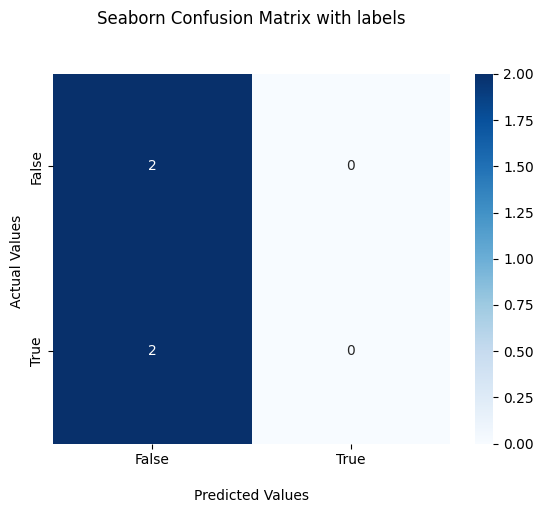

In [25]:
y_preds = np.argmax(model.predict(testloader), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("vivit_cf.png")


### Visualise predictions

In [29]:
NUM_SAMPLES_VIZ = 25

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = X_test[:NUM_SAMPLES_VIZ], y_test[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", duration=2)
        videos_.append(gif.getvalue())


    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb






boxes = []
label_dict = {0: 'noFight', 1: 'Fight'}

# Limit the loop to the minimum of NUM_SAMPLES_VIZ and the length of videos_
for i in range(min(NUM_SAMPLES_VIZ, len(videos_))):
    ib = ipywidgets.widgets.Image(value=videos_[i], width=200, height=200)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)




#boxes = []
#label_dict = {0: 'noFight', 1: 'Fight'}
#for i in range(NUM_SAMPLES_VIZ):
 #   ib = ipywidgets.widgets.Image(value=videos_[i], width=200, height=200)
  #  true_class = label_dict[ground_truths[i]]
   # pred_class = label_dict[preds[i]]
    #caption = f"T: {true_class} | P: {pred_class}"

    #boxes.append(make_box_for_grid(ib, caption))

#ipywidgets.widgets.GridBox(
 #   boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
#)

1/1 [==============================] - 0s 116ms/step


GridBox(children=(VBox(children=(HTML(value="'T: Fight | P: noFight'"), Box(children=(Image(value=b'GIF89a\x80…

# Comparative results on test set

The vivit classifier provides poor performance compare to the CNN-RNN architecture due to the very small size of the dataset. Transformer-based models have a large number of parameters thus require a big dataset otherwise they will be easily prone to overfitting. In the other side, the CNN-RNN architecture uses a pre-trained feature extractor instead of learning features from the provided dataset only. For this reason the CNN-RNN provided better results even with a very small dataset.

In [37]:
df = pd.DataFrame([vivit_scores, cnn_rnn_scores])
df.columns= ['Accuracy', 'Recall', 'Precision', 'F1']
df.index = ['ViViT', 'CNN-RNN']

df.head()

,Accuracy,Recall,Precision,F1
ViViT,0.50,1.0,0.5,0.666667
CNN-RNN,0.75,1.0,0.5,0.666667


### Plot confusion matrices side by side

[0.5, 1.0, 0.5, 0.6666666269302368]
[0.75, 1.0, 0.5, 0.6666666269302368]


Text(0.5, 1.0, 'CNN-RNN CLASSIFIER')

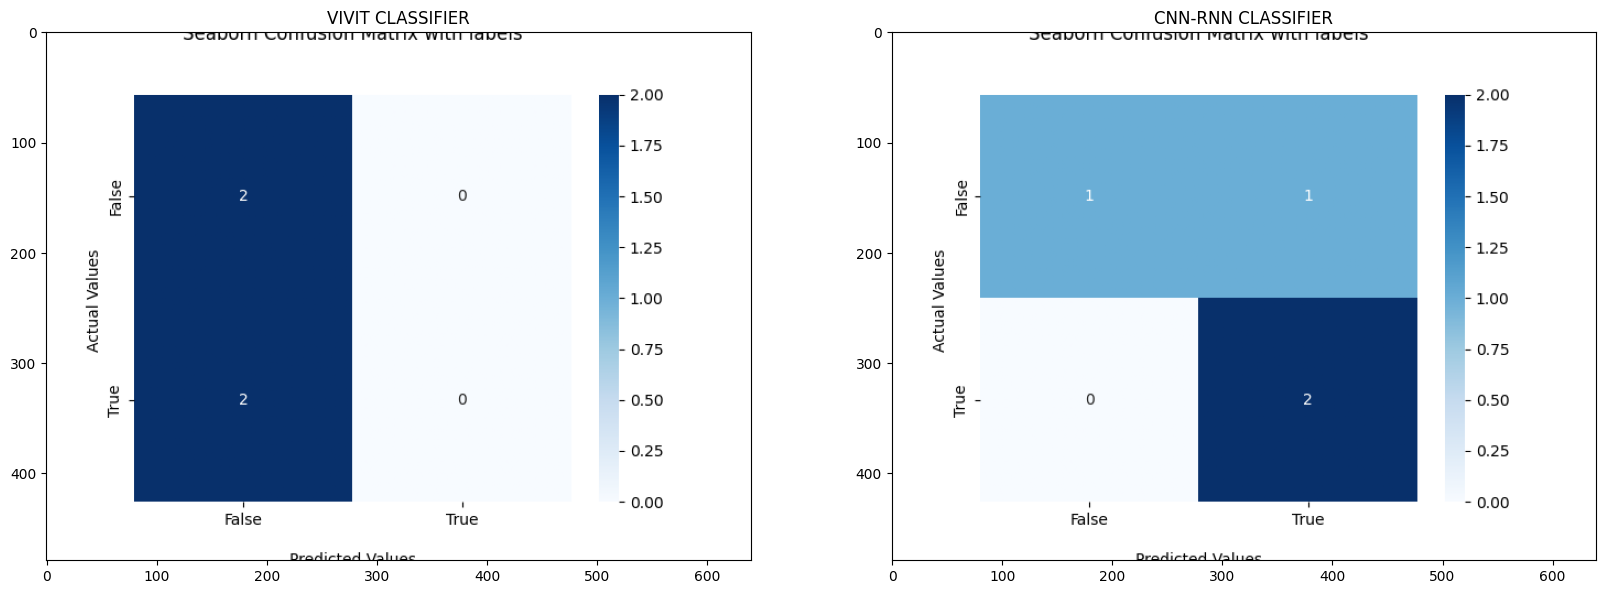

In [38]:
print(vivit_scores)
print(cnn_rnn_scores)

im1 = plt.imread('vivit_cf.png')
im2 = plt.imread('cnn_rnn_cf.png')

f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(im1)
axarr[0].set_title('VIVIT CLASSIFIER')
axarr[1].imshow(im2)
axarr[1].set_title('CNN-RNN CLASSIFIER')

## Model interpretability

Model features can be interpreted using the SHAP library

*Work in Progress*

In [40]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.2 MB/s eta 0:00:00


In [43]:

import numpy as np

# Check the shape of X_train_features
print("Shape of X_train_features:", X_train_features.shape)

# Adjust the number of samples to match the population size
num_samples = min(100, X_train_features.shape[0])

# Sample from X_train_features
background = X_train_features[np.random.choice(X_train_features.shape[0], num_samples, replace=False)]



Shape of X_train_features: (12, 42, 2048)
